# Let's start!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_probability as tfp

from sklearn.model_selection import train_test_split

### Choose model and define hyper-parameters

- Model is chosen from TensorFlow Hub (https://tfhub.dev/)
- Recommended values for the parameters can be found on the TensorFlow Hub page

In [2]:
batch_size = 32

# Choose a model on TensorFlow Hub. We chose EfficientNet B3
hub_url = "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1"

# Use the recommended image size for your model. For EfficientNet B3, it is 300x300
IMG_HEIGHT = 300
IMG_WIDTH = 300

NUM_CLASSES = 42

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Import data

### Sample the dataframe to get a balanced dataset

Strategy:
- Duplicate the dataframe until it has more than `NUM_SAMPLE`
- Sample `NUM_SAMPLE` rows from that dataframe
- Split train, test set

This means that there are duplicate entries in the test set, which is a problem

For illustration purpose, only 100 samples per class are taken

In [3]:
# Change this to specify the number of samples per class
NUM_SAMPLE = 100
# NUM_SAMPLE = 2700

train_df = pd.read_csv('train.csv')

def resample_split(df):
    # Calculate how many times extra copies of the dateframe will be added
    n = np.floor(NUM_SAMPLE / len(df)).astype('int')
    old_df = df.copy()
    
    for i in range(n):
        df = df.append(old_df, ignore_index=True)

    # Take NUM_SAMPLE samples from the dataframe
    df = df.sample(NUM_SAMPLE, random_state=0)
    
    # Split train, test set, and indicate that in an extra column
    train, test = train_test_split(df, test_size=0.1, random_state=0)
    train['train'] = True
    test['train'] = False

    return train.append(test, ignore_index=True)

# Apply resample_split(df) to each category
train_df = train_df.groupby('category').apply(resample_split)
train_df = train_df.reset_index(drop=True)

# Add full path to file
train_df['path'] = './train/train/' + train_df['category'].astype('str').str.pad(2, fillchar='0') + '/' + train_df['filename']
train_df

,filename,category,train,path
0,71a300abcc8e32ed5cb9db1023be4763.jpg,0,True,./train/train/00/71a300abcc8e32ed5cb9db1023be4...
1,77a926ee397cec2c7d3748be4e38c529.jpg,0,True,./train/train/00/77a926ee397cec2c7d3748be4e38c...
2,c63f93fb89d5bdce7825ca29cc65e3d0.jpg,0,True,./train/train/00/c63f93fb89d5bdce7825ca29cc65e...
3,262768d6c4b3251748f9d3d6c633f1e2.jpg,0,True,./train/train/00/262768d6c4b3251748f9d3d6c633f...
4,51de641fdbe15a5d38bb9ebad9b99419.jpg,0,True,./train/train/00/51de641fdbe15a5d38bb9ebad9b99...
...,...,...,...,...
4195,0b6880aa3c318fe29e41fc4c1b3c11c3.jpg,41,False,./train/train/41/0b6880aa3c318fe29e41fc4c1b3c1...
4196,30e40b49c5e82ee75375a972942b77fa.jpg,41,False,./train/train/41/30e40b49c5e82ee75375a972942b7...
4197,6540c724d07903d3f3f135957330a2a3.jpg,41,False,./train/train/41/6540c724d07903d3f3f135957330a...
4198,67c5b9dba5281ab45a3bace5cfe5e6f3.jpg,41,False,./train/train/41/67c5b9dba5281ab45a3bace5cfe5e...


In [4]:
train_path_df = train_df[train_df['train']].sample(frac=1)
val_path_df = train_df[train_df['train'] == False]

num_train = len(train_path_df)
num_train

3780

### Use the column `category` and `path` to create a TensorFlow Dataset object

In the `import_images()` function:
- Load image from path
- Convert label to a vector

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((train_path_df['path'], train_path_df['category'])).cache().shuffle(num_train)
val_ds = tf.data.Dataset.from_tensor_slices((val_path_df['path'], val_path_df['category'])).cache()

def import_images(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Convert to float32 and resize
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

    label = tf.range(42, dtype=tf.int64) == label

    return img, tf.cast(label, tf.float32)

train_ds = train_ds.map(import_images, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(import_images, num_parallel_calls=AUTOTUNE)

Take one example and draw it out

Label:  tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(42,), dtype=float32)


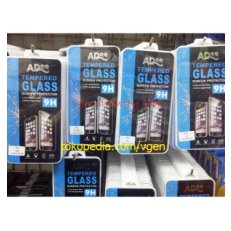

In [6]:
for img, label in train_ds.take(1):
    print('Label: ', label)
    plt.imshow(img.numpy())
    plt.axis('off')

### Apply augmentation and cutout

For simple augmentation:
- Randomly flip horizontally
- Randomly crop the image `200x200` and scale it back to original size

For cutout:
- Randomly cutout 1 to 10 squares
- The cutout area is roughly the same
- `tfa.image.random_cutout` takes a batch of images as its input, thus have to `.batch()` the dataset before applying cutout

In [7]:
def augment(image, label):
    # Random flip and crop
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, [200, 200, 3])
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    
    return image,label

def cutout(imgs, labels):
    # Randomly cutout 1 to 10 squares
    n = int(np.ceil(np.random.random()*10))
    size = int(100/np.sqrt(n))
    
    for i in range(n):
        imgs = tfa.image.random_cutout(imgs, (size, size))
    return imgs, labels

train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE).batch(batch_size).map(cutout, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)

Show the effect of augmentation

Image shape:  (300, 300, 3)
Label:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


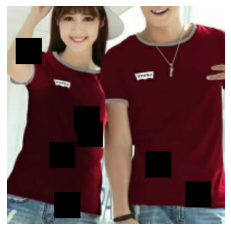

In [8]:
for batch in train_ds.take(1):
    img = batch[0][0]
    label = batch[1][0]
    print("Image shape: ", img.numpy().shape)
    print("Label: ", label.numpy())
    plt.imshow(img.numpy())
    plt.axis('off')

### Apply mixup

- Create two datasets from the dataframe, same as above
- `mixup()` takes one sample from each dataset and combines it into one sample (linear combination)
- The combination factor is a number sampled from the Beta distribution

In [9]:
def mixup(sample1, sample2):
    image1, label1 = sample1
    image2, label2 = sample2
    
    dist = tfp.distributions.Beta(0.2, 0.2)
    l = dist.sample(1)
    a = 1-l

    img = a*image1 + l*image2
    label = a*label1 + l*label2
    
    return img, label

train_ds1 = tf.data.Dataset.from_tensor_slices((train_path_df['path'], train_path_df['category'])).cache().shuffle(num_train).map(import_images)
train_ds2 = tf.data.Dataset.from_tensor_slices((train_path_df['path'], train_path_df['category'])).cache().shuffle(num_train).map(import_images)

train_mixup_ds = tf.data.Dataset.zip((train_ds1, train_ds2)).map(mixup)

Illustrate mixup

Label:  tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.9076036  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.09239638 0.         0.         0.
 0.         0.         0.         0.         0.         0.        ], shape=(42,), dtype=float32)


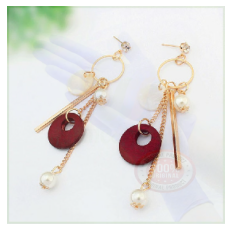

In [10]:
for img, label in train_mixup_ds.take(1):
    print('Label: ', label)
    plt.imshow(img.numpy())
    plt.axis('off')

Batching

In [11]:
train_mixup_ds = train_mixup_ds.batch(batch_size).prefetch(AUTOTUNE)

## Create model

### Import pre-trained model from TensorFlow Hub
- Set `trainable=False` to learn the weights for our new classification layer
- Add a classification layer with `NUM_CLASSES` outputs, corresponding to the probabilities for each class

In [12]:
base_model = hub.KerasLayer(hub_url, trainable=False) # Can be True, see below.

model = tf.keras.Sequential([
    base_model,  
    tf.keras.layers.Dense(NUM_CLASSES)
])
model.build([None, IMG_HEIGHT, IMG_WIDTH, 3]) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  10783528  
_________________________________________________________________
dense (Dense)                multiple                  64554     
Total params: 10,848,082
Trainable params: 64,554
Non-trainable params: 10,783,528
_________________________________________________________________


### Compile the model

Specify the optimizer and optimizer. Some suggestions:

- `tf.keras.optimizers.RMSprop(learning_rate=0.01)`
- `tf.keras.optimizers.Adam(learning_rate=0.01)`
- `tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)`

Usually, we use `Adam` or `RMSprop` when first started training a new model. For finetuning, `SGD` is better
- Recommended parameters can be found in the original research paper of the chosen paper

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

## Load weights

Load saved weights from previous runs

**Don't run this if you are not loading saved weights**

In [ ]:
weights_path = './weights/example'
model.load_weights(weights_path)

## Train the model

- Change `filepath` to specify the save location
- Change `epochs` to specify the number of epochs

If you want to continue training, can either re-run this cell, or run a new cell (make another copy of this cell below)
- To change the optimizer, re-run the `model.compile()` cell with a different optimizer

Can swap `train_ds` with `train_mixup_ds` to train with the mixup dataset

In [14]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./weights/example',
                                                 save_weights_only=True,
                                                 label_smoothing=0.1,
                                                 verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[cp_callback]
)

Epoch 1/10
119/119 [==============================] - ETA: 0s - loss: 10.0652 - accuracy: 0.4971
Epoch 00001: saving model to ./weights/example
119/119 [==============================] - 61s 510ms/step - loss: 10.0652 - accuracy: 0.4971 - val_loss: 11.6268 - val_accuracy: 0.5690
Epoch 2/10
118/119 [============================>.] - ETA: 0s - loss: 7.7887 - accuracy: 0.6409
Epoch 00002: saving model to ./weights/example
119/119 [==============================] - 59s 497ms/step - loss: 7.7896 - accuracy: 0.6407 - val_loss: 12.7488 - val_accuracy: 0.6000
Epoch 3/10
118/119 [============================>.] - ETA: 0s - loss: 7.3013 - accuracy: 0.6846
Epoch 00003: saving model to ./weights/example
119/119 [==============================] - 58s 490ms/step - loss: 7.2935 - accuracy: 0.6849 - val_loss: 14.1466 - val_accuracy: 0.5976
Epoch 4/10
118/119 [============================>.] - ETA: 0s - loss: 6.0710 - accuracy: 0.7225
Epoch 00004: saving model to ./weights/example
119/119 [============

## Evaluation on the validation set

Draw the confusion matrix for the validation set

In [15]:
# This will take some time ~1 minute
logits = model.predict(val_ds)

- Use `softmax` function to convert logits to probabilities
- Get class label from index of the probabilities vector
- Draw the confusion matrix

Text(87.0, 0.5, 'True')

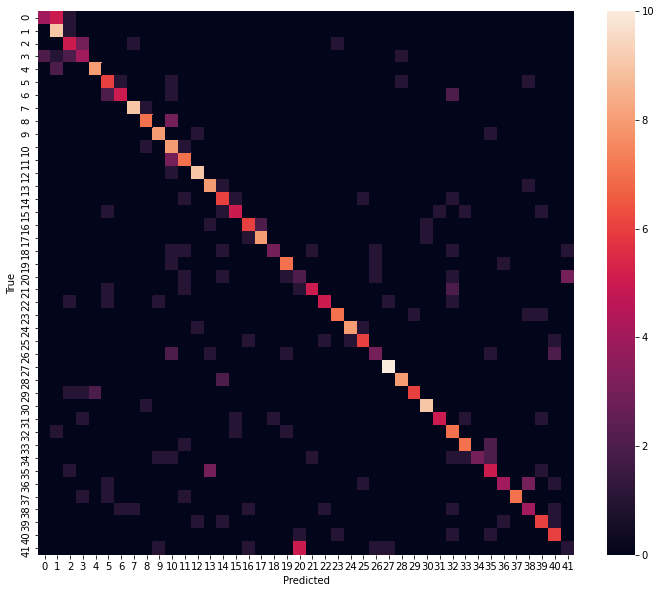

In [16]:
probs = tf.nn.softmax(logits)
predictions = np.argmax(probs.numpy(), axis=1)

confusion_matrix = tf.math.confusion_matrix(val_path_df['category'].to_numpy(), predictions)
plt.figure(figsize=(12,10))
sns.heatmap(confusion_matrix.numpy())
plt.xlabel("Predicted")
plt.ylabel("True")

Plot accuracies accross classes

<BarContainer object of 42 artists>

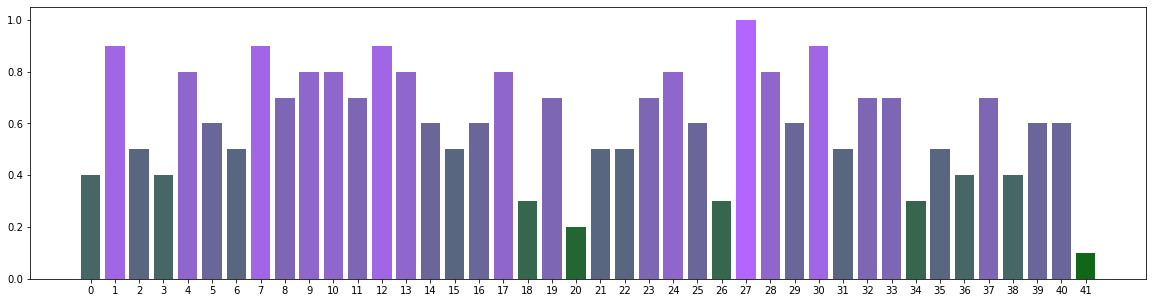

In [17]:
accuracies = np.diagonal(confusion_matrix) / (NUM_SAMPLE/10)

plt.figure(figsize=(20,5))
plt.bar(np.arange(NUM_CLASSES), accuracies, color=[(0.7*x, 0.4, x) for x in accuracies], tick_label=np.arange(NUM_CLASSES))

## Finetuning

Allow training on the pre-trained model

In [18]:
base_model.trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  10783528  
_________________________________________________________________
dense (Dense)                multiple                  64554     
Total params: 10,848,082
Trainable params: 10,760,786
Non-trainable params: 87,296
_________________________________________________________________


Compile again if you wish to change the optimizer or learning rate
- For finetuning, usually SGD optimizer and low learning rate (e.g. 0.001) are better

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.003, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

Same training code as above to continue training

In [20]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./weights/example',
                                                 save_weights_only=True,
                                                 label_smoothing=0.1,
                                                 verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[cp_callback]
)

Epoch 1/5
119/119 [==============================] - ETA: 0s - loss: 12.2853 - accuracy: 0.0765
Epoch 00001: saving model to ./weights/example
119/119 [==============================] - 135s 1s/step - loss: 12.2853 - accuracy: 0.0765 - val_loss: 100.2957 - val_accuracy: 0.0238
Epoch 2/5
119/119 [==============================] - ETA: 0s - loss: 4.0625 - accuracy: 0.0929
Epoch 00002: saving model to ./weights/example
119/119 [==============================] - 129s 1s/step - loss: 4.0625 - accuracy: 0.0929 - val_loss: 12.3360 - val_accuracy: 0.0405
Epoch 3/5
119/119 [==============================] - ETA: 0s - loss: 3.6280 - accuracy: 0.1638
Epoch 00003: saving model to ./weights/example
119/119 [==============================] - 132s 1s/step - loss: 3.6280 - accuracy: 0.1638 - val_loss: 5.3618 - val_accuracy: 0.0905
Epoch 4/5
119/119 [==============================] - ETA: 0s - loss: 3.3674 - accuracy: 0.1963
Epoch 00004: saving model to ./weights/example
119/119 [======================

# Evaluate test set

Import test data and perform the same treatment as train data above

In [21]:
test_df = pd.read_csv('test.csv')

test_df['path'] = './test/test/' + test_df['filename']
test_df

,filename,category,path
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43,./test/test/fd663cf2b6e1d7b02938c6aaae0a32d2.jpg
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43,./test/test/c7fd77508a8c355eaab0d4e10efd6b15.jpg
2,127f3e6d6e3491b2459812353f33a913.jpg,43,./test/test/127f3e6d6e3491b2459812353f33a913.jpg
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43,./test/test/5ca4f2da11eda083064e6c36f37eeb81.jpg
4,46d681a542f2c71be017eef6aae23313.jpg,43,./test/test/46d681a542f2c71be017eef6aae23313.jpg
...,...,...,...
12181,5ba958eacb23cd7d1673bad4dae55784.jpg,43,./test/test/5ba958eacb23cd7d1673bad4dae55784.jpg
12182,efbe41a1c2b666b70e337e438559808b.jpg,43,./test/test/efbe41a1c2b666b70e337e438559808b.jpg
12183,79fdaa5ac5ba10dbe8004cabd8c35eb3.jpg,43,./test/test/79fdaa5ac5ba10dbe8004cabd8c35eb3.jpg
12184,ac3d136124617637a05ba66694e381ef.jpg,43,./test/test/ac3d136124617637a05ba66694e381ef.jpg


In [22]:
test_ds = tf.data.Dataset.from_tensor_slices((test_df['path']))

In [23]:
def import_test(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Convert to float32 and resize
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

    return img

test_ds = test_ds.map(import_test).batch(batch_size).prefetch(AUTOTUNE)

### Draw a few test images

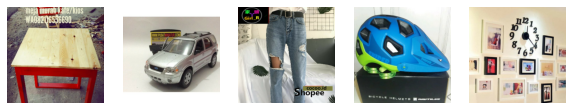

In [24]:
plt.figure(figsize=(10,50))
for batch in test_ds.take(1):
    x =  5
    i = 0
    for i in range(5):
        plt.subplot(1, x, i+1)
        plt.imshow(batch[i].numpy())
        plt.axis('off')
        i += 1

In [25]:
logits = model.predict(test_ds)
len(logits)

12186

In [26]:
probs = tf.nn.softmax(logits)
predictions = np.argmax(probs.numpy(), axis=1)

### See predicted labels for a few test images

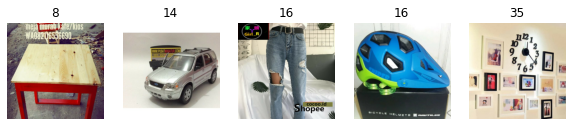

In [27]:
plt.figure(figsize=(10,50))
for batch in test_ds.take(1):
    x =  5
    i = 0
    for i in range(5):
        plt.subplot(1, x, i+1)
        plt.imshow(batch[i].numpy())
        plt.title(predictions[i])
        plt.axis('off')
        i += 1

### Create the dataframe and output to csv

In [28]:
output_df = pd.DataFrame({'filename': test_df['filename'], 'category': predictions})
output_df['category'] = output_df['category'].astype('str').str.pad(2, fillchar="0")
output_df

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,08
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,14
2,127f3e6d6e3491b2459812353f33a913.jpg,16
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,16
4,46d681a542f2c71be017eef6aae23313.jpg,35
...,...,...
12181,5ba958eacb23cd7d1673bad4dae55784.jpg,16
12182,efbe41a1c2b666b70e337e438559808b.jpg,16
12183,79fdaa5ac5ba10dbe8004cabd8c35eb3.jpg,14
12184,ac3d136124617637a05ba66694e381ef.jpg,14


In [29]:
output_df.to_csv('./output.csv', index=False)